In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time, timedelta
from sklearn.model_selection import train_test_split
from optimal_f import OptimalF
from joblib import Parallel, delayed

In [32]:
df = pd.read_csv('../csv/BTCUSDT_1m_20210801_20221231.csv')
display(df)

# Assume 80% of the data is used for training and 20% for testing
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

,date,open,high,low,close,volume
0,1627743660000,41340.58,41347.05,41340.58,41347.05,0.000546
1,1627743720000,41347.05,41347.05,41320.71,41320.71,0.001308
2,1627743780000,41320.71,41320.71,41309.40,41309.40,0.001086
3,1627743840000,41309.40,41314.08,41309.40,41314.08,0.000481
4,1627743900000,41314.08,41327.25,41314.08,41327.25,0.002747
...,...,...,...,...,...,...
740795,1672413540000,16508.20,16512.86,16498.28,16508.61,15.606035
740796,1672413600000,16508.61,16523.98,16504.91,16504.91,18.356253
740797,1672413660000,16504.91,16513.00,16502.58,16510.18,7.890198
740798,1672413720000,16510.18,16517.09,16499.36,16517.09,9.953238


In [33]:
def summarize_trade_results(trade_results):
    num_trades = len(trade_results['profits'])
    num_wins = sum(1 for x in trade_results['profits'] if x > 0)
    num_losses = num_trades - num_wins

    average_win = sum(x for x in trade_results['profits'] if x > 0) / num_wins if num_wins > 0 else 0
    average_loss = sum(x for x in trade_results['profits'] if x < 0) / num_losses if num_losses > 0 else 0

    profit_factor = -average_win / average_loss if average_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0
    net_profit = sum(trade_results['profits'])

    # Print the statistics
    print("Total trade Num:", len(trade_results['profits']))
    print("Net Profit: {:.2f}".format(net_profit))
    print("Profit Factor: {:.2f}".format(profit_factor))
    print("Long Trade Num:", len(trade_results['long_profits']))
    print("Long Win Rate: {:.2f}".format(long_win_rate))
    print("Short Trade Num:", len(trade_results['short_profits']))
    print("Short Win Rate: {:.2f}".format(short_win_rate))

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [34]:
# Indicator
from ta.momentum import RSIIndicator

def prepare_data(df):
    # Calculate moving averages
    df['short_ma'] = df['close'].rolling(window=50).mean()
    df['long_ma'] = df['close'].rolling(window=200).mean()

    # Determine the trend
    df.loc[df['short_ma'] > df['long_ma'], 'trend'] = 1
    df.loc[df['short_ma'] < df['long_ma'], 'trend'] = 0

    rsi_indicator = RSIIndicator(close=df['close'])
    df['RSI'] = rsi_indicator.rsi()
    
    return df

# trade logic
def trade_conditions1(data_row, portfolio): 
    """
        Total trade Num: 593055
        Net Profit: 29656.43
        Profit Factor: 693.46
        Long Trade Num: 415
        Long Win Rate: 0.64
        Short Trade Num: 597
        Short Win Rate: 0.67
    """
    rsi = data_row['RSI']
    trend = data_row['trend']

    if portfolio['position'] == 'long' and rsi > 70:
        return 'exit_long'
    elif portfolio['position'] == 'short' and rsi < 20:
        return 'exit_short'
    elif rsi < 20 and trend == 0:
        return 'entry_long'
    elif rsi > 70 and trend == 1:
        return 'entry_short'
    else:
        return None
    
# trade logic
def trade_conditions2(data_row, portfolio): 
    """
        Total trade Num: 592821
        Net Profit: 18142.82
        Profit Factor: 972.00
        Long Trade Num: 181
        Long Win Rate: 0.61
        Short Trade Num: 677
        Short Win Rate: 0.64
    """
    rsi = data_row['RSI']
    trend = data_row['trend']

    if portfolio['position'] == 'long' and rsi > 70:
        return 'exit_long'
    elif portfolio['position'] == 'short' and rsi < 20:
        return 'exit_short'
    elif rsi < 20 and trend == 1: # 売られすぎた後にトレンドが変換したと仮定
        return 'entry_long'
    elif rsi > 70 and trend == 0: # 買われすぎた後にトレンドが変換したと仮定
        return 'entry_short'
    else:
        return None
    
# trade logic
def trade_conditions3(data_row, portfolio): 
    """
        Total trade Num: 592953
        Net Profit: 10841.94
        Profit Factor: 1656.46
        Long Trade Num: 313
        Long Win Rate: 0.64
        Short Trade Num: 0
        Short Win Rate: 0.00
    """
    rsi = data_row['RSI']
    trend = data_row['trend']

    if portfolio['position'] == 'long' and rsi > 76:
        return 'exit_long'
    elif rsi < 20 and trend == 1:
        return 'entry_long'
    else:
        return None

In [35]:
def trade_logic(df):
    # Initialize trade_results
    trade_results = {
        'profits': [],
        'long_profits': [],
        'short_profits': [],
    }

    # Initialize portfolio state
    portfolio = {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0
    }

    # Loop through the data
    for i in range(0, len(df)):
        profit = 0

        data_row = df.iloc[i]
        action = trade_conditions3(data_row, portfolio)

        if portfolio['position'] is not None:
            if action == 'exit_long':
                profit = data_row['close'] - portfolio['entry_price']
                trade_results['profits'].append(profit)
                trade_results['long_profits'].append(profit)
                portfolio = {
                    'position': None,
                    'entry_price': None,
                    'entry_point': 0
                }

            if action == 'exit_short':
                profit = portfolio['entry_price'] - data_row['close']
                trade_results['profits'].append(profit)
                trade_results['short_profits'].append(profit)
                portfolio = {
                    'position': None,
                    'entry_price': None,
                    'entry_point': 0
                }

            else:
                trade_results['profits'].append(profit)
        
        elif action == 'entry_long':
            trade_results['profits'].append(profit)
            portfolio = {
                'position': 'long',
                'entry_price': data_row['close'],
                'entry_point': i
            }

        elif action == 'entry_short':
            trade_results['profits'].append(profit)
            portfolio = {
                'position': 'short',
                'entry_price': data_row['close'],
                'entry_point': i
            }

        else:
            trade_results['profits'].append(profit)

    return trade_results

Total trade Num: 592926
Net Profit: -2871.70
Profit Factor: 1583.69
Long Trade Num: 286
Long Win Rate: 0.64
Short Trade Num: 0
Short Win Rate: 0.00


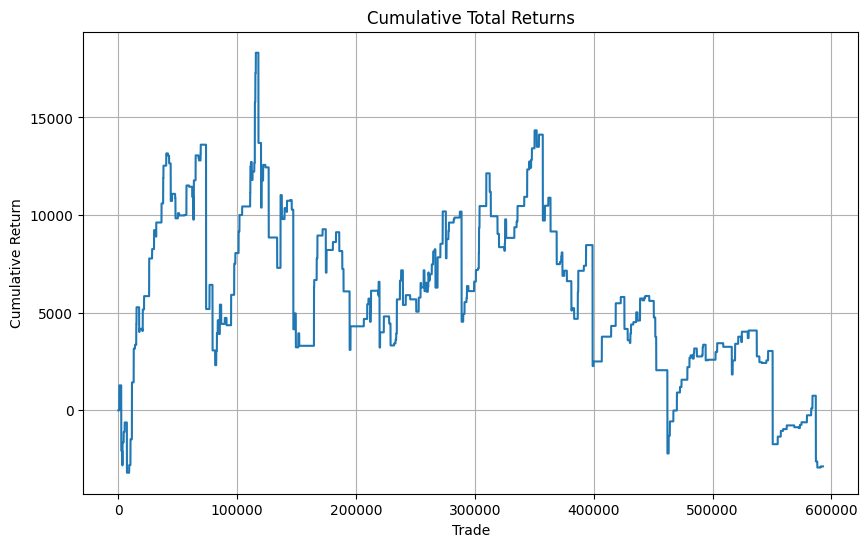

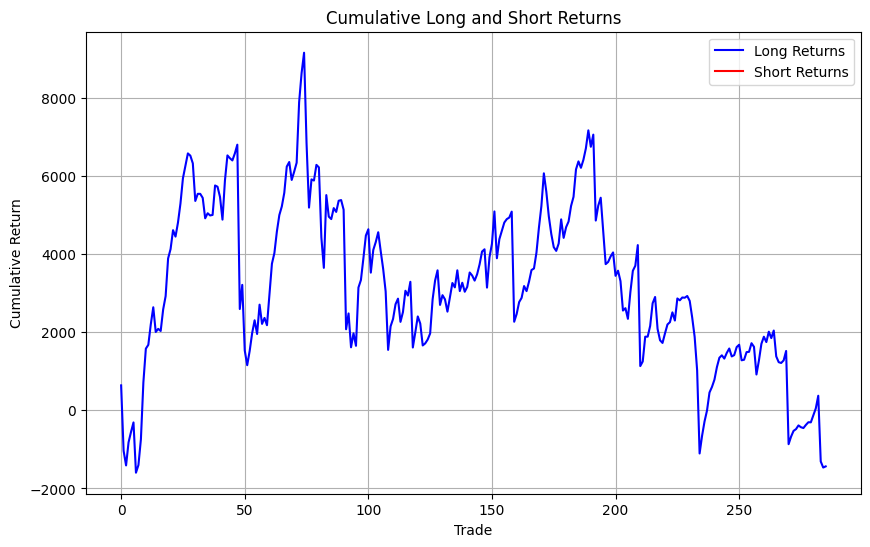

In [36]:
# Backtest
if __name__ == '__main__':
    # Specify the DataFrame to be used in the backtest
    df = train_df

    # Prepare the data
    df = prepare_data(df)

    # Execute the trade logic
    trade_results = trade_logic(df)

    # Summarize the trade results
    summarize_trade_results(trade_results)

    # Update OptimalF calculator with trade results and calculate optimal_f
    # opt_f_calculator.set_trade_returns(trade_results['profits'])
    # opt_f = opt_f_calculator.calculate()
    # print("Optimal f:", opt_f)

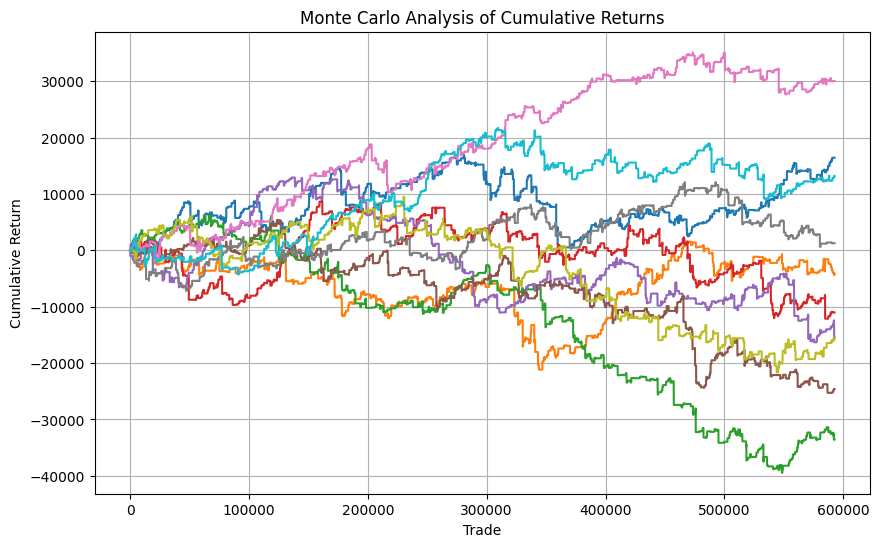

In [41]:
def monte_carlo_simulation(df, num_simulations=1000, num_trades=None):
    if num_trades is None:
        num_trades = len(df)
        
    df = prepare_data(df)
    original_trade_results = trade_logic(df)
    profits = original_trade_results['profits']

    results = Parallel(n_jobs=-1)(delayed(run_simulation)(profits, num_trades) for _ in range(num_simulations))
    return results

def run_simulation(profits, num_trades):
    simulated_profits = np.random.choice(profits, num_trades)
    cumulative_returns = np.cumsum(simulated_profits)
    
    return cumulative_returns



df = train_df
num_simulations = 400
results = monte_carlo_simulation(df, num_simulations)

plt.figure(figsize=(10,6))
for cumulative_returns in results:
    plt.plot(cumulative_returns)
plt.title("Monte Carlo Analysis of Cumulative Returns")
plt.xlabel("Trade")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In [43]:
import pandas as pd

def analyze_results(results, original_trade_results):
    # DataFrameの表示形式を変更
    pd.options.display.float_format = '{:.2f}'.format
    
    # 元データの計算
    original_metrics = calculate_metrics(original_trade_results['profits'])

    # シミュレーション結果の計算
    simulated_metrics = [calculate_metrics(cumulative_returns) for cumulative_returns in results]

    # 集計結果の作成
    summary = {
        '平均': {key: np.mean([metrics[key] for metrics in simulated_metrics]) for key in original_metrics},
        '標準偏差': {key: np.std([metrics[key] for metrics in simulated_metrics]) for key in original_metrics},
        '上振れ95%': {key: np.percentile([metrics[key] for metrics in simulated_metrics], 95) for key in original_metrics},
        '下振れ95%': {key: np.percentile([metrics[key] for metrics in simulated_metrics], 5) for key in original_metrics},
        '元データ': original_metrics
    }

    # DataFrameとして表示
    summary_df = pd.DataFrame(summary)
    return summary_df

def calculate_metrics(profits):
    cumulative_returns = np.cumsum(profits)
    max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))
    recovery_factor = cumulative_returns[-1] / -max_drawdown if max_drawdown != 0 else np.nan

    metrics = {
        '純損益': cumulative_returns[-1],
        '期待利得': np.mean(profits),
        'プロフィットファクター': np.sum([p for p in profits if p > 0]) / -np.sum([p for p in profits if p < 0]) if np.sum([p for p in profits if p < 0]) != 0 else np.inf,
        '最大ドローダウン': max_drawdown,
        'リカバリーファクター': recovery_factor,
        'シャープレシオ': np.mean(profits) / np.std(profits)
    }
    return metrics

# 分析結果の表示
df = prepare_data(df)
original_trade_results = trade_logic(df)
summary_df = analyze_results(results, original_trade_results)
display(summary_df)


,平均,標準偏差,上振れ95%,下振れ95%,元データ
純損益,377681731.75,5357441414.64,8853748584.95,-6269011899.18,-2871.70
期待利得,637.29,9039.96,14939.51,-10578.11,-0.00
プロフィットファクター,1700.35,4322.32,9081.84,0.02,0.98
最大ドローダウン,-2347176655.50,2515807768.19,-2110009.79,-6557366744.85,-21247.68
リカバリーファクター,1715.69,4325.48,9153.58,-0.99,-0.14
シャープレシオ,0.16,1.11,1.86,-1.11,-0.00
